## Data Base Manager  
This notebook displays one way you can interact with ```restaurant_review_database.db```  
___

### Relational Schema
<img src="figs/erd_review_agg.png">

### Import Modules

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from database_manager_class import RestaurantReviewDB

### Helper Functions

In [127]:
def plot_rating_count_behavior_over_time(weekly_group:pd.DataFrame, compare_df:pd.DataFrame = None, res_name:str = None) -> None:
        """
        Displays the behavior of rating mean and rating count over time. 
        If compare_df is provided (default is None), two sources of data will be compared. This is designed to compare one restaurant with 
        the overall mean.
        """
        fig, ax1 = plt.subplots(figsize= (15, 8))
        ax1.plot(weekly_group["date"], 
                weekly_group["rating_mean"], 
                color = "r", 
                marker = "*", 
                label = "Rating Mean")
        if compare_df is not None:
                ax1.plot(compare_df["date"],
                                compare_df["rating_mean"],
                                color = "black",
                                label = f"{res_name} Mean")
        ax1.fill_between(weekly_group["date"], 
                        weekly_group["rating_mean"] - weekly_group["rating_std"], 
                        weekly_group["rating_mean"] + weekly_group["rating_std"], 
                        color = "r", 
                        alpha = .1, 
                        label="Mean ± Std Dev")
        ax1.set_xlabel("Date", weight = "bold", fontsize = 12)
        ax1.set_ylabel("Review Mean", weight = "bold", fontsize = 12, color = "r")
        ax1.tick_params(axis = "y", labelcolor = "r")
        ax1.set_ylim((1, 6))
        ax1.legend(loc='upper left')
        ax1.set_xticks(weekly_group['date'])
        ax1.set_xticklabels(weekly_group['date'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

        ax2 = ax1.twinx()
        ax2.bar(weekly_group["date"], 
                weekly_group["rating_count"],
                color = "b",
                alpha = 0.7,
                label = "Review Count")
        ax2.set_ylabel('Review Count', color='b', weight='bold', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.set_ylim((0, 500))
        ax2.legend(loc='upper right')

        # Add title
        plt.title('Mean Rating and Review Count Over Time:\n Duration 1 Year', weight = "bold", fontsize = 20)
        plt.tight_layout()

___  
### Set Global Params
This block sets the file names to the database and the $4$ curated data files that contain the data to be inserted into the database.

In [128]:
DB_FILE_NAME                = "restaurant_review_database.db"
YELP_REVIEW_DATA_FILE       = "yelp_review_data_Portland_ME_2024-06-29.csv_CURATED.csv"
YELP_RESTUARANT_DATA_FILE   = "yelp_restaurant_data_Portland_ME_2024-06-29_CURATED.csv"
OPEN_TABLE_REVIEW_DATE_FILE = "open_table_review_data_Portland_ME_2024-07-21.csv_CURATED.csv"
OPEN_TABLE_RES_DATE_FILE    = "open_table_restaurant_data_Portland_ME_2024-07-21.csv_CURATED.csv"

# Set to True if you want to insert data
insert_data = False

___  
### Insert Data into the database  
This block inserts the data.

In [7]:
if insert_data:
    ResDB = RestaurantReviewDB(DB_FILE_NAME)
    ResDB.connect()
    ResDB.create_tables()
    ResDB.set_open_table_data(OPEN_TABLE_REVIEW_DATE_FILE, OPEN_TABLE_RES_DATE_FILE)
    ResDB.set_yelp_data(YELP_REVIEW_DATA_FILE, YELP_RESTUARANT_DATA_FILE)
    ResDB.load_site_origin_table()
    ResDB.load_region_table()
    ResDB.load_tags_table()
    ResDB.load_price_point_table()
    ResDB.load_restuarant_table()
    ResDB.load_res_tags_table()
    ResDB.load_reviewer_table()
    ResDB.load_restaurant_review_table()
    ResDB.load_aux_rating_table()
else:
    ResDB = RestaurantReviewDB(DB_FILE_NAME)

___
### Use Database  
Now we can perform an EDA using the database ```query``` method and ```SQLite``` syntax.  

We will start by querying for all the review ratings for all the restaurants to inspect some general statistics.

In [129]:
# Define the query
query = """ 
        SELECT R.rating,
               R.date,
               Re.name,
               S.site_name
        FROM res_review AS R
        JOIN restaurant AS Re ON R.restaurant_id = Re.id
        JOIN site_origin AS S ON R.site_origin_id = S.id 
        """

# Execute query
result = ResDB.query(query)

In [139]:
result

,rating,date,name,site_name
0,5,2024-07-20,street and co.,open_table
1,5,2024-07-19,street and co.,open_table
2,3,2024-07-18,street and co.,open_table
3,4,2024-07-18,street and co.,open_table
4,5,2024-07-16,street and co.,open_table
...,...,...,...,...
37989,5,2015-11-01,taj indian cuisine,Yelp
37990,4,2015-10-29,taj indian cuisine,Yelp
37991,4,2015-09-27,taj indian cuisine,Yelp
37992,1,2015-09-25,taj indian cuisine,Yelp


___  
#### Inspect Counts by Site Origin

In [130]:
result.groupby("site_name").count()

,rating,date,name
site_name,,,
Yelp,33348,33348,33348
open_table,4646,4646,4646


___  
### Inspect distribution of rating
Visualize distribution  
Display measures of center and dispersion: ( $\mu$, $\sigma$ )

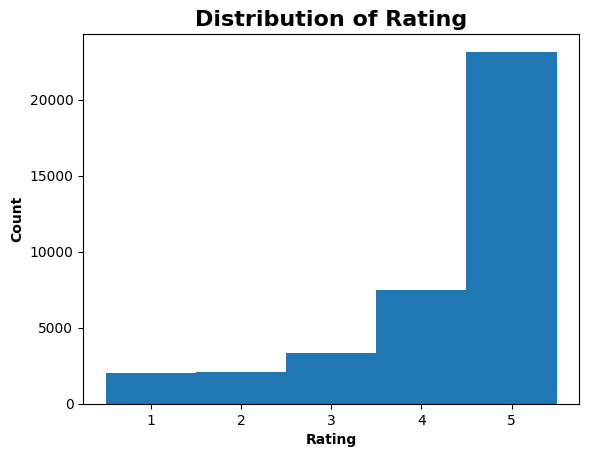

In [131]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
plt.hist(result["rating"], bins = bins)
plt.title("Distribution of Rating", weight = "bold", fontsize = 16)
plt.xlabel("Rating", weight = "bold")
plt.ylabel("Count", weight = "bold");

In [132]:
print(f"Rating Mean: {round(result['rating'].mean(), 2)}")
print(f"Rating Standard Deviation: {round(result['rating'].std(), 2)}")

Rating Mean: 4.25
Rating Standard Deviation: 1.15


___  
#### Aggregate Data By Week  
Here we will inspect how rating behaves over time.  

Are there elements of periodicity?  
Can count be used as a proxy for how busy (tourism) a region is? 

In [133]:
# Convert data string to pd.DateTime
result["date"] = pd.to_datetime(result["date"], format = "%Y-%m-%d", errors = "coerce")

# Filter for two years of data
filter_duration = pd.Timestamp("2024-07-01") - pd.DateOffset(years = 1)
result_filtered = result[result["date"] >= filter_duration]

In [134]:
# Here we'll aggregate weekly data
weekly_group = result_filtered.groupby(pd.Grouper(key = "date", freq = "W")).agg(rating_count = ("rating", "count"),
                                                                                 rating_mean = ("rating", "mean"),
                                                                                 rating_std = ("rating", "std"))

In [135]:
# Reset the index for ease of use
weekly_group.reset_index(inplace = True)

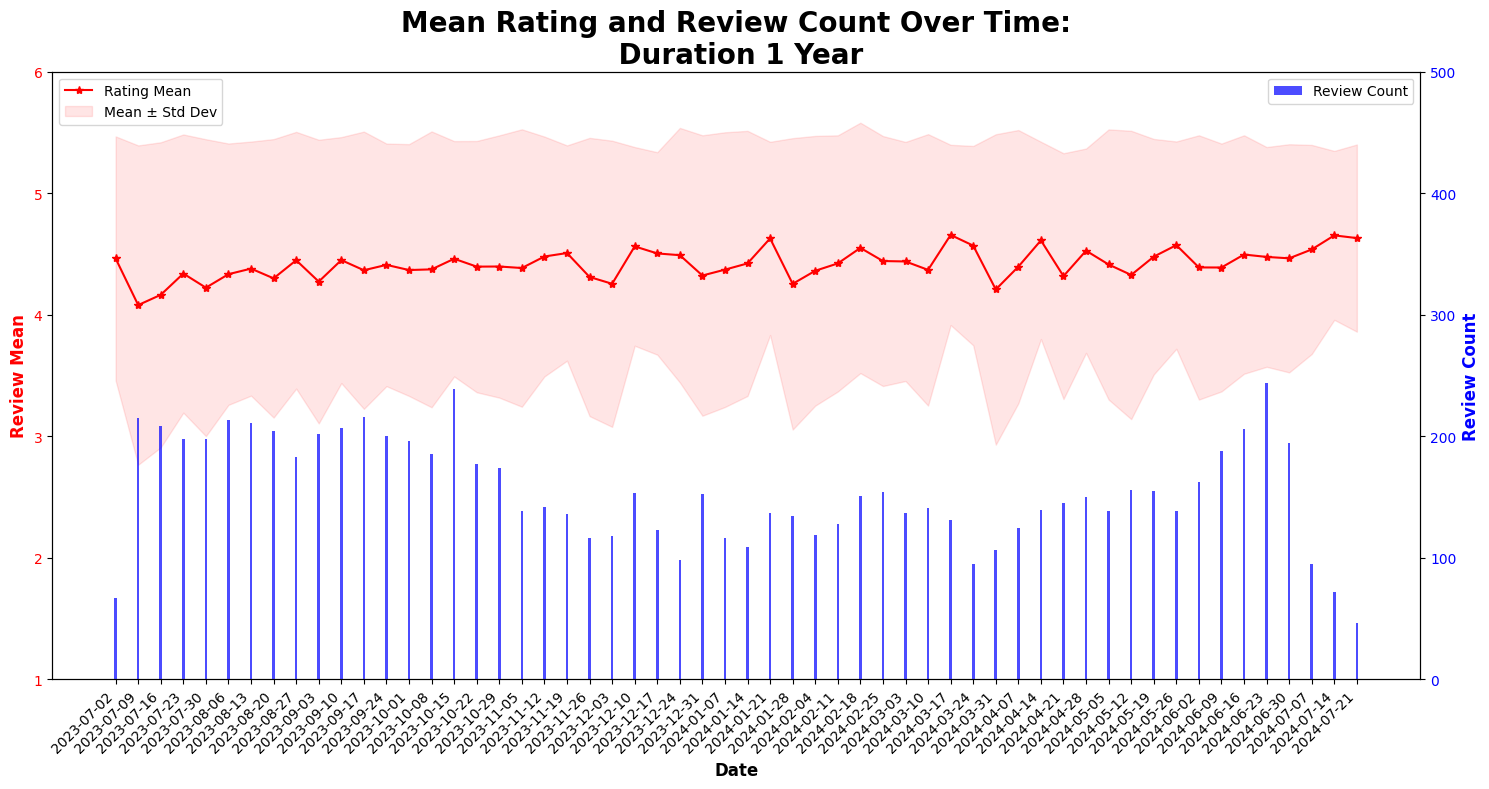

In [136]:
plot_rating_count_behavior_over_time(weekly_group)